In [114]:
import matplotlib.pyplot as plt
import numpy as np
import seawater
import xarray as xr
import scipy.signal as sp
import pandas as pd
import math
import sys
import time


np.set_printoptions(threshold=50)

%matplotlib inline

## Integrate PSSC in ONAV
This notebook contains the update as we move forward integrating Potential Sub-Surface channel variable in Navigator following option 3 (A fixed frequency cutoff value) 
### Importing the sample profile

In [115]:
profile = pd.read_csv("sample-pssc-profiles/ts_giops_day_2021-01-22T17_20_15.578175_POSITIVE.csv", header=2)
profile.columns

Index(['Latitude', 'Longitude', 'Depth (m)', 'Pressure', 'Salinity',
       'Temperature', 'Sound Speed'],
      dtype='object')

Text(0.5, 0, 'Speed of sound [m/s]')

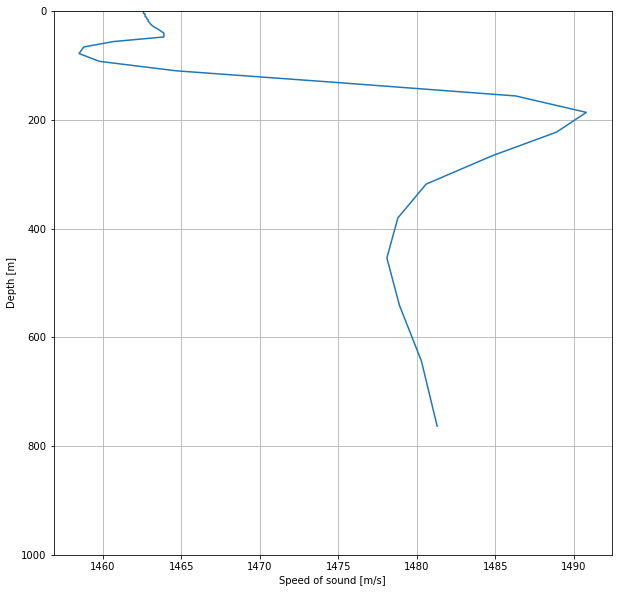

In [116]:
depth = profile['Depth (m)']
Profile_sspeed = profile['Sound Speed']
temperature = profile ['Temperature']
salinity = profile ['Salinity']
latitude = profile['Latitude']
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(profile['Sound Speed'], profile['Depth (m)'])
ax.grid(True)
ax.set_ylim([1000,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Speed of sound [m/s]')

### Bringing in functions from Navigator
These functions below are from Ocean-Data-Map-Project/data/calculated_parser/functions.py

https://github.com/DFO-Ocean-Navigator/Ocean-Data-Map-Project/blob/master/data/calculated_parser/functions.py

In [121]:
def __calc_pressure(depth, latitude):
    pressure = []
    try:
        pressure = [seawater.pres(d, latitude) for d in depth]
    except TypeError:
        pressure = seawater.pres(depth, latitude)

    return np.array(pressure)

def __validate_depth_lat_temp_sal(depth, latitude, temperature, salinity):

    if type(depth) is not np.ndarray:
        depth = np.array(depth)

    if type(latitude) is not np.ndarray:
        latitude = np.array(latitude)

    if type(temperature) is not np.ndarray:
        temperature = np.array(temperature)

    if type(salinity) is not np.ndarray:
        salinity = np.array(salinity)

    return depth, latitude, np.squeeze(temperature), np.squeeze(salinity)

def sspeed(depth, latitude, temperature, salinity):
    """
    Calculates the speed of sound.
    Required Arguments:
    * depth: The depth(s) in meters
    * latitude: The latitude(s) in degrees North
    * temperature: The temperatures(s) in Celsius
    * salinity: The salinity (unitless)
    """

    depth, latitude, temperature, salinity = __validate_depth_lat_temp_sal(
        depth, latitude, temperature, salinity)

    press = __calc_pressure(depth, latitude)

    if salinity.shape != press.shape:
        # pad array shape to match otherwise seawater freaks out
        press = press[..., np.newaxis]

    speed = seawater.svel(salinity, temperature, press)
    return np.squeeze(speed)

In [122]:
calculated_sspeed = sspeed(depth, latitude, temperature, salinity)
calculated_sspeed.shape

(34, 34, 34)

### The functions to detect sub-surface channel (Single point calculation)

In [4]:
def calculate_del_C(depth,latitude,temperature, salinity, freq_cutoff):
    """
     Calculate ΔC from a given sound profile and freq cutoff
     Required Arguments:
        * depth: The depth(s) in meters
        * latitude: The latitude(s) in degrees North
        * temperature: The temperatures(s) in Celsius
        * salinity: The salinity (unitless)
        * freq_cutoff: Desired frequency cutoff in Hz
     Returns the value of ΔC, which will later be used inside the 
    """
    depth, latitude, temperature, salinity = __validate_depth_lat_temp_sal(depth, latitude, temperature, salinity)
    
    soundspeed = sspeed(depth, latitude, temperature, salinity);
    print(soundspeed.shape)
    # Getting Cmin from the sound speed profile
    first_local_minimum = sp.find_peaks(-soundspeed)[0][0]
    Cmin = soundspeed[first_local_minimum]
    #Calculating del_Z
    local_maximum = sp.find_peaks(soundspeed)[0][0]
    channel_start_depth = depth[local_maximum]
    channel_end_depth = np.interp(soundspeed[local_maximum], soundspeed, depth) 
    del_Z = channel_end_depth - channel_start_depth
    # print(channel_start_depth)
    # Final calculation of delC
    numerator = freq_cutoff * del_Z
    denominator = 0.2652 * Cmin
    final_denom = numerator/denominator
    final_denom =np.power(final_denom,2)
    delC = float(Cmin/final_denom)
    return delC

#calculate_del_C(depth,latitude, temperature, salinity, 2755.03);

In [5]:
"""
     Detect if there is sub-surface channel. 
     Required Arguments:
        * depth: Depth in meters
        * sspeed: Sound speed in m/s
     Returns 1 if the profile has a sub-surface channel, 0 if the profile does not have a sub-surface channel
"""
def detect_potential_sub_surface_channel_v3(depth, latitude,temperature, salinity, freq_cutoff = 2755.03 )-> bool:
    has_PSSC = 0
    del_C = calculate_del_C(depth,latitude,temperature, salinity, freq_cutoff)
    # Trimming the profile considering the depth above 1000m
    depth = depth[depth<1000]
    sspeed = sspeed[0:(len(depth))]
    # detecting the local minima and local maxima for the sound speed profile
    local_minima = sp.find_peaks(-sspeed)[0] # get the index array of local minima
    local_maxima = sp.find_peaks(sspeed)[0] # get the index array of local maxima
    if len(local_minima)>=2: #if there are 2 or more minima
        p1 = 0 # surface
        p2 = local_minima[0] #first minimum
        if len(local_maxima)>=2: # if there are more than one maxima
            p1 = local_maxima[0] #first maximum
            p3 = local_maxima[1] #second maximum
        else: #only one local maximum
            p3 =  local_maxima[0] 
            if p3 < p2: # the only one maxima is higher in the water column than the minima
                has_PSSC=0
        # print("p1 p2 p3 : " +str(p1)+" "+str(p2)+" "+str(p3))
        p1_sound_speed = sound_speed[p1]
        p2_sound_speed = sound_speed[p2]
        p3_sound_speed = sound_speed[p3]
    
        c1 = abs(p1_sound_speed-p2_sound_speed) 
        c2 = abs(p3_sound_speed-p2_sound_speed)
        #print("c1 = "+ str(c1) +"m/s")
        #print("c2 = "+ str(c2) +"m/s")
    
        if c1> del_C and c2> del_C: # Changing this comparison to check with the calculated ΔC
            has_PSSC =1
        else:
            has_PSSC =0
    else:
        has_PSSC =0 
    #print(local_minima)
    #print(local_maxima)
    return has_PSSC

### Transforming the function for inputs from NetCDF file

In [123]:
d = xr.open_dataset('data/2019100100_000_3D_ps5km60N.nc')
d

<xarray.Dataset>
Dimensions:              (depth: 75, time: 1, xc: 1770, yc: 1610)
Coordinates:
  * xc                   (xc) float32 0.0 5000.0 10000.0 ... 8840000.0 8845000.0
  * yc                   (yc) float32 0.0 5000.0 10000.0 ... 8040000.0 8045000.0
    latitude             (yc, xc) float32 ...
    longitude            (yc, xc) float32 ...
  * depth                (depth) float32 0.50753 1.55757 ... 5698.06 5902.06
  * time                 (time) datetime64[ns] 2019-10-01
Data variables:
    polar_stereographic  |S1 ...
    votemper             (time, depth, yc, xc) float32 ...
    vosaline             (time, depth, yc, xc) float32 ...
    vozocrtx             (time, depth, yc, xc) float32 ...
    vomecrty             (time, depth, yc, xc) float32 ...
Attributes:
    Conventions:      CF-1.6
    title:            Time-averaged sea ice and ocean forecast fields
    institution:      The Canadian Centre for Meteorological and Environmenta...
    source:           Regional Ice Oce

In [124]:
depth = d.depth.values
temp = d.votemper.values
sal = d.vosaline.values
lat = d.latitude.values

In [125]:
depth2 = depth[depth<1000]
depth2.shape
temp = temp-273.15


In [126]:
temp2 = temp[:,0:len(depth2),:,:]
print(temp2.shape)
sal2 =  sal[:,0:len(depth2),:,:]
print(sal2.shape)

(1, 46, 1610, 1770)
(1, 46, 1610, 1770)


In [127]:
#sound_speed = np.ma.array(sspeed(depth2, lat, temp2, sal2), fill_value=np.nan)
sound_speed = sspeed(depth2, lat, temp2, sal2)
#sound_speed

/home/sourav/.conda/envs/navigator/lib/python3.6/site-packages/seawater/eos80.py:928: RuntimeWarning: invalid value encountered in sqrt
  return Cw + A * s + B * s * s ** 0.5 + D * s ** 2


In [128]:
sound_speed

array([[[      nan,       nan,       nan, ..., 1544.4917, 1544.4845,
         1544.4814],
        [      nan,       nan,       nan, ..., 1544.5295, 1544.5255,
         1544.5214],
        [      nan,       nan,       nan, ..., 1544.5731, 1544.5751,
         1544.5582],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 1544.5092, 1544.5018,
         1544.4988],
        [      nan,       nan,       nan, ..., 1544.5471, 1544.543 ,
         1544.539 ],
        [      nan,       nan,       nan, ..., 1544.5905, 1544.5925,
         1544.5757],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
   

In [11]:
start = time.time()
sound_speed.shape
minima = np.apply_along_axis(sp.find_peaks,0,-sound_speed)
end = time.time()
print(end-start)
minima.shape

40.87394189834595


(2, 1610, 1770)

__need to check it for an expected size of soundspeed__ 

In [60]:
sound_speed_sliced = sound_speed[:,200:286,-126:]
sound_speed_sliced.shape

(46, 86, 126)

In [15]:
start = time.time()
minima_alt = np.apply_along_axis(sp.find_peaks,0,-sound_speed_sliced)
end = time.time()
print(end-start)
minima_alt = minima_alt[0]
minima_alt

0.21399545669555664


array([[array([33]), array([33]), array([32]), ...,
        array([], dtype=int64), array([], dtype=int64), array([10, 29])],
       [array([33]), array([33]), array([33]), ...,
        array([], dtype=int64), array([29]), array([28])],
       [array([33]), array([33]), array([33]), ..., array([28]),
        array([27]), array([26])],
       ...,
       [array([], dtype=int64), array([], dtype=int64),
        array([], dtype=int64), ..., array([], dtype=int64), array([15]),
        array([], dtype=int64)],
       [array([], dtype=int64), array([], dtype=int64),
        array([], dtype=int64), ..., array([], dtype=int64),
        array([], dtype=int64), array([], dtype=int64)],
       [array([], dtype=int64), array([], dtype=int64),
        array([], dtype=int64), ..., array([], dtype=int64),
        array([], dtype=int64), array([], dtype=int64)]], dtype=object)

In [39]:
first_minimum = np.empty_like(minima_alt, dtype='int64')
start = time.time()
it = np.nditer(minima_alt,flags=['refs_ok','multi_index'])
for x in it:
    minima_size = x.tolist().size
    first_minimum[it.multi_index]= x.tolist()[0] if minima_size>0 else -1
end = time.time()
print("Execution time :",end-start," seconds")
first_minimum

Execution time : 0.011584281921386719  seconds


array([[33, 33, 32, ..., -1, -1, 10],
       [33, 33, 33, ..., -1, 29, 28],
       [33, 33, 33, ..., 28, 27, 26],
       ...,
       [-1, -1, -1, ..., -1, 15, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [41]:
first_minimum

array([[33, 33, 32, ..., -1, -1, 10],
       [33, 33, 33, ..., -1, 29, 28],
       [33, 33, 33, ..., 28, 27, 26],
       ...,
       [-1, -1, -1, ..., -1, 15, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [42]:
Cmin = np.take_along_axis(sound_speed_sliced, first_minimum[np.newaxis,:, :], axis=0)
Cmin

array([[[1525.0265, 1524.7672, 1524.791 , ..., 1494.8286, 1494.87  ,
         1538.9507],
        [1525.6283, 1525.4158, 1525.1793, ..., 1494.6204, 1521.0939,
         1520.7916],
        [1526.3643, 1526.2228, 1525.9893, ..., 1521.0095, 1520.7137,
         1520.2833],
        ...,
        [1498.5297, 1499.2789, 1499.9965, ..., 1501.3119, 1538.0911,
         1501.8351],
        [1498.5299, 1499.2776, 1499.9625, ..., 1501.3688, 1501.6146,
         1501.8928],
        [1498.5605, 1499.278 , 1499.9297, ..., 1501.3663, 1501.675 ,
         1501.9532]]], dtype=float32)

Testing if this worked. Checking it with directly indexing the actual value and output. 

In [27]:
sound_speed_sliced[10,0,-1]

1538.9507

Squeezing the ndarray to remove the 0th axis of length 1

In [50]:
print(Cmin.shape)
Cmin = np.squeeze(Cmin)
print(Cmin.shape)

(1, 86, 126)
(86, 126)


In [63]:
Cmin[first_minimum==-1] = np.nan


In [64]:
Cmin

array([[1525.0265, 1524.7672, 1524.791 , ...,       nan,       nan,
        1538.9507],
       [1525.6283, 1525.4158, 1525.1793, ...,       nan, 1521.0939,
        1520.7916],
       [1526.3643, 1526.2228, 1525.9893, ..., 1521.0095, 1520.7137,
        1520.2833],
       ...,
       [      nan,       nan,       nan, ...,       nan, 1538.0911,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)

In [146]:
maxima_alt =  np.apply_along_axis(sp.find_peaks,0,sound_speed_sliced)
maxima_alt.shape

(2, 86, 126)

In [147]:
maxima_alt = maxima_alt[0]
first_maximum = np.empty_like(maxima_alt, dtype='int64')
it = np.nditer(maxima_alt,flags=['refs_ok','multi_index'])
for x in it:
    array_size = x.tolist().size
    first_maximum[it.multi_index] =x.tolist()[0] if array_size>0 else -1 
first_maximum.shape


(86, 126)

[1536.4102 1536.4275 1536.4457 1536.4655 1536.4857 1536.5072 1536.5254
 1536.562  1536.5977 1536.6288 1536.6832 1536.7343 1536.7786 1536.8771
 1537.0223 1537.1189 1537.2682 1537.2988 1537.2733 1536.6635 1534.6617
 1532.6857 1531.0387 1529.7146 1528.6113 1527.6776 1526.9155 1526.3359
 1525.9105 1525.5741 1525.3445 1525.1759 1525.0461 1525.0265 1525.0343
 1525.0503 1524.9766 1524.5059 1523.4587 1521.764  1519.0134 1516.3818
 1513.3048 1508.9286 1503.3217 1498.6824]
[1536.3809 1536.3983 1536.4176 1536.4362 1536.4567 1536.478  1536.4965
 1536.5328 1536.5684 1536.5996 1536.6353 1536.6865 1536.7494 1536.9154
 1537.0702 1537.1597 1537.2095 1537.206  1537.0063 1535.9331 1533.9792
 1532.1991 1530.7406 1529.5586 1528.5825 1527.7798 1527.1515 1526.6635
 1526.3044 1525.991  1525.76   1525.5692 1525.4587 1525.4158 1525.4683
 1525.531  1525.5564 1525.3126 1524.5728 1523.0991 1520.5068 1517.752
 1514.3314 1510.1364 1504.3422 1499.4005]


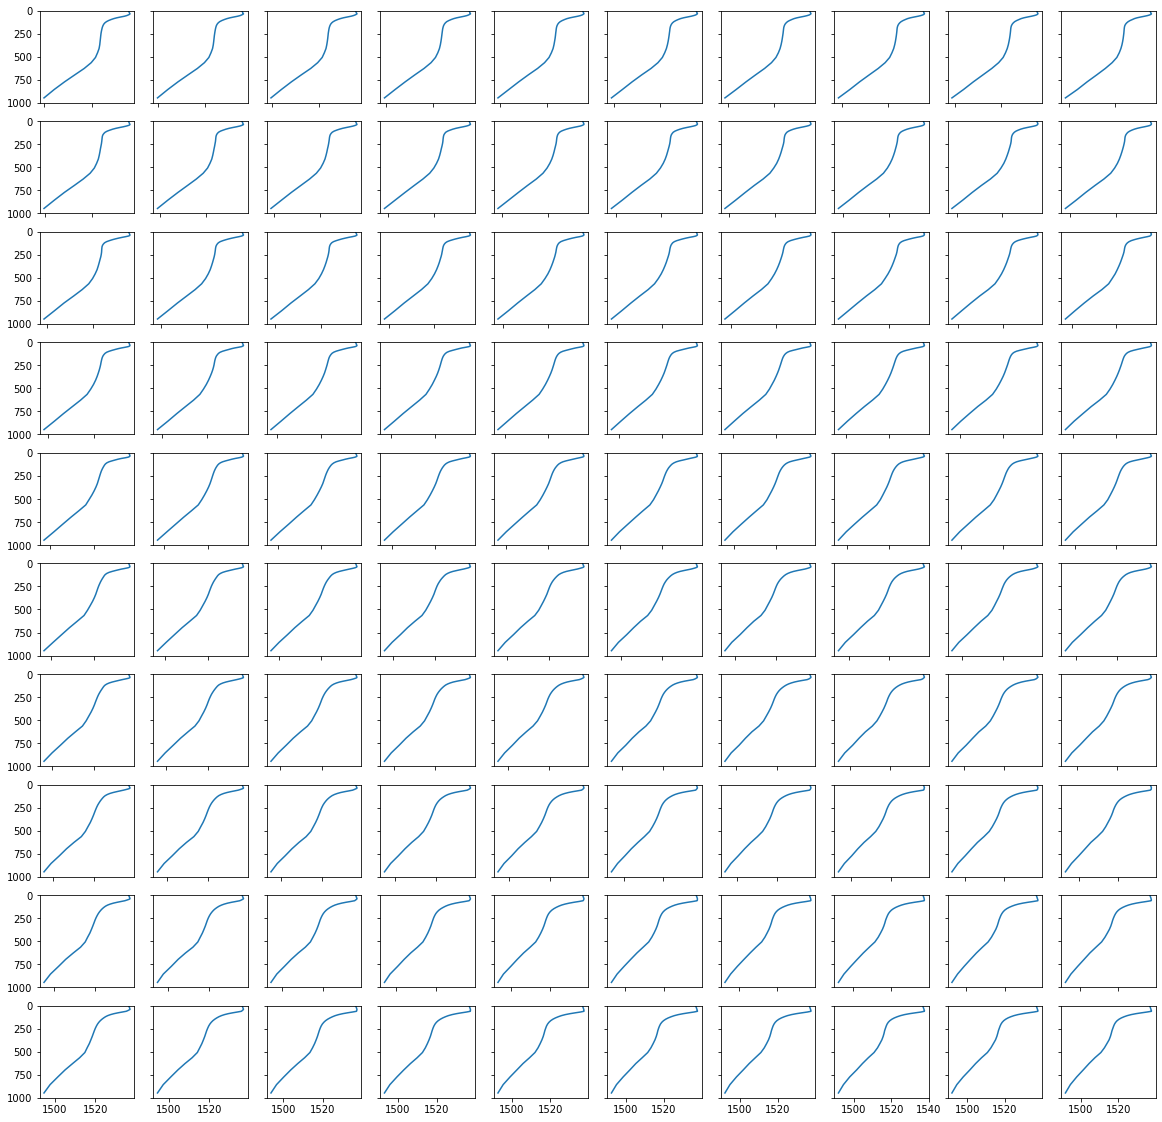

In [226]:
fig, axs = plt.subplots(10, 10,figsize=(20,20))
#axs[0, 0].plot(sound_speed_sliced[:,0,0], depth2)
#axs[0,0].set_ylim([1000,0])
print(sound_speed_sliced[:,0,0])
print(sound_speed_sliced[:,1,1])
for i in range(10):
    for j in range(10):
        axs[i,j].plot(sound_speed_sliced[:,15+i,16+j], depth2)
        axs[i,j].set_ylim([1000,0])
        axs[i,j].label_outer()


In [239]:
#def calculate_del_C(depth, soundspeed, freq_cutoff):
from scipy import stats
def calculate_del_C(depth,soundspeed,minima,maxima, freq_cutoff):
    """
     Calculate ΔC from a given sound profile and freq cutoff
     Required Arguments:
        * depth: The depth(s) in meters
        * soundspeed: Speed of sound in m/s
        * minima: Minima ndarray of Speed of sound, which contains the index where the minima occurs
        * maxima: Maxima ndarray of Speed of sound,  which contains the index where the maxima occurs
        * freq_cutoff: Desired frequency cutoff in Hz
     Returns the value of ΔC, which will later be used inside the PSSC detection method
    """
    # Getting Cmin from the sound speed profile
    first_minimum = np.empty_like(minima, dtype='int64')
    # TODO: need to look at alternative for the following operation
    it = np.nditer(minima,flags=['refs_ok','multi_index'])
    for x in it:
        array_size = x.tolist().size
        first_minimum[it.multi_index]= x.tolist()[0] if array_size>0 else -1
    Cmin = np.squeeze(np.take_along_axis(soundspeed, first_minimum[np.newaxis,:, :], axis=0))
    Cmin[first_minimum==-1] = np.nan
    #calculating delZ
    first_maximum = np.empty_like(maxima, dtype='int64')
    it = np.nditer(maxima,flags=['refs_ok','multi_index'])
    for x in it:
        array_size = x.tolist().size
        first_maximum[it.multi_index] =x.tolist()[0] if array_size>0 else -1 
    channel_start_depth = depth[first_maximum]
    channel_start_depth[first_maximum==-1] = np.nan
    Cmax = np.squeeze(np.take_along_axis(soundspeed, first_maximum[np.newaxis,:, :], axis=0))
    Cmax[first_minimum==-1] = np.nan
    #channel_end_depth = np.apply_along_axis(np.interp,0, Cmax,soundspeed,depth) 
    channel_end_depth = np.empty_like(Cmax,dtype='float')
    it = np.nditer(Cmax,flags=['refs_ok','multi_index'])
    for x in it:
        channel_end_depth[it.multi_index] = np.interp(x, soundspeed[:,it.multi_index[0], it.multi_index[1]],depth)
    del_Z = channel_end_depth-channel_start_depth
    numerator = freq_cutoff * del_Z
    denominator = 0.2652 * Cmin
    final_denom = numerator/denominator 
    final_denom = np.power(final_denom,2)
    delC = Cmin/final_denom
    print(delC)
    return delC

#def potentialsubsurfacechannel(depth, latitude,temperature, salinity, freq_cutoff = 2755.03 )-> bool:
def potentialsubsurfacechannel(depth, sound_speed, freq_cutoff = 2755.03 )-> bool:   
    """
     Detect if there is sub-surface channel. 
     Required Arguments:
        * depth: Depth in meters
        * latitude: Latitude in degrees North
        * temperature: Temperatures in Celsius
        * salinity: Salinity
     Returns 1 if the profile has a sub-surface channel, 0 if the profile does not have a sub-surface channel
    """
    #print(depth)
    has_PSSC = 0
    # Trimming the profile considering the depth above 1000m
    depth = depth[depth<1000]
    #temp = temperature[:,0:len(depth),:,:]
    #sal =  salinity[:,0:len(depth),:,:]
    #sound_speed = np.ma.array(sspeed(depth, latitude, temp, sal), fill_value=np.nan)
    minima = np.apply_along_axis(sp.find_peaks,0,-sound_speed)[0] # selecting the first item
    maxima = np.apply_along_axis(sp.find_peaks,0, sound_speed)[0]
    del_C = calculate_del_C(depth,sound_speed,minima,maxima, freq_cutoff)
    
    
    #########
    
    sound_speed = sound_speed[0:(len(depth))]
    
    
    # detecting the local minima and local maxima for the sound speed profile
    local_minima = sp.find_peaks(-sound_speed)[0] # get the index array of local minima
    local_maxima = sp.find_peaks(sound_speed)[0] # get the index array of local maxima
    
    
    
    if len(local_minima)>=2: #if there are 2 or more minima
        p1 = 0 # surface
        p2 = local_minima[0] #first minimum
        if len(local_maxima)>=2: # if there are more than one maxima
            p1 = local_maxima[0] #first maximum
            p3 = local_maxima[1] #second maximum
        else: #only one local maximum
            p3 =  local_maxima[0] 
            if p3 < p2: # the only one maxima is higher in the water column than the minima
                has_PSSC=0
        # print("p1 p2 p3 : " +str(p1)+" "+str(p2)+" "+str(p3))
        p1_sound_speed = sound_speed[p1]
        p2_sound_speed = sound_speed[p2]
        p3_sound_speed = sound_speed[p3]
    
        c1 = abs(p1_sound_speed-p2_sound_speed) 
        c2 = abs(p3_sound_speed-p2_sound_speed)
        #print("c1 = "+ str(c1) +"m/s")
        #print("c2 = "+ str(c2) +"m/s")
    
        if c1> del_C and c2> del_C: # Changing this comparison to check with the calculated ΔC
            has_PSSC =1
        else:
            has_PSSC =0
    else:
        has_PSSC =0 
    #print(local_minima)
    #print(local_maxima)
    return has_PSSC


In [240]:
potentialsubsurfacechannel(depth, sound_speed_sliced, 2755.03)

[[4.05520558e-05 4.11358525e-05 4.05332760e-05 ...            nan
             nan 3.87595954e-05]
 [4.00614437e-05 4.00447031e-05 4.00260830e-05 ...            nan
  3.78659386e-05 3.78433739e-05]
 [4.01194451e-05 4.01082929e-05 4.00898811e-05 ... 3.78596396e-05
  3.78375591e-05 3.80780359e-05]
 ...
 [           nan            nan            nan ...            nan
  4.01333319e-05            nan]
 [           nan            nan            nan ...            nan
             nan            nan]
 [           nan            nan            nan ...            nan
             nan            nan]]


TypeError: only size-1 arrays can be converted to Python scalars